In [108]:
# pip install python-binance pandas mplfinance vaderSentiment snscrape pytrends

In [109]:
import pandas as pd
from pytrends.request import TrendReq
import numpy as np                      
from datetime import datetime,timedelta                 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import  mean_absolute_error,mean_squared_error, r2_score,f1_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from tensorflow.keras.models import  Sequential
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import  LSTM, Dense, Dropout, Input,Flatten, InputLayer
plt.style.use('Solarize_Light2')


In [110]:
df = pd.read_csv('total_data')

In [111]:
df1 = df[['Close','score','Bitcoin']].dropna()
df1.rename(columns={'Close':'Price', 'score':'sentiment_score','Bitcoin':'search_trend'},inplace=True)
dates = pd.to_datetime(df['Unnamed: 0']).iloc[1:].to_list()

In [112]:
scaler = StandardScaler()
df2 = scaler.fit_transform(df1)
def preprocess(data,window= 15):
  X,Y = [],[]
  for i in range(len(data)-window):
     features=data[i:i+window]
     label = data[i+window][0]
     X.append(features)
     Y.append(label)

  return np.array(X), np.array(Y)

In [113]:
X,Y=  preprocess(df2,7)

In [114]:
train_size = int(0.8 * len(X))
end_val = int(0.9 * len(X))

x_train,y_train,dates_train = X[:train_size], Y[:train_size],dates[:train_size]
x_val,y_val,dates_val = X[train_size:end_val], Y[train_size:end_val],dates[train_size:end_val]
x_test,y_test,dates_val = X[end_val:], Y[end_val:], dates[end_val:]
x_train.shape,x_val.shape,x_test.shape

((1193, 7, 3), (149, 7, 3), (150, 7, 3))

In [115]:
model=Sequential()
model.add(InputLayer((x_train.shape[1],x_train.shape[2])))
model.add(LSTM(40,activation='linear'))
model.add(Dense(20, activation='linear'))
model.add(Dense(10, activation='linear'))
model.add(Dense(1))
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0001))

In [ ]:
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=12 ,epochs =100)

In [117]:
train_test_pred = model.predict(x_test)

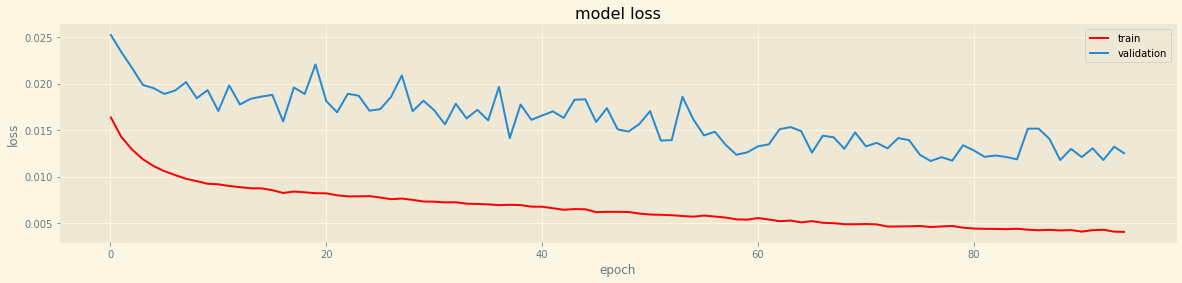

0.0649731892004562
0.007237748489737159


In [118]:
plt.figure(figsize=(20,4))
plt.plot(history.history['loss'][5:],color='r')
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
print(mean_absolute_error(train_test_pred.flatten(),y_test.flatten()))
print(mean_squared_error(train_test_pred.flatten(),y_test.flatten()))

Mean Absolute Error for test data: 1172.0957828125001
Mean Absolute Percentage Error for test data: 0.0466279728403836
Mean Squared Error for test data: 2355381.9968704567
Root Mean Squared Error for test data: 1534.7253815814922
R2 Score for test data: 0.9297227131926121


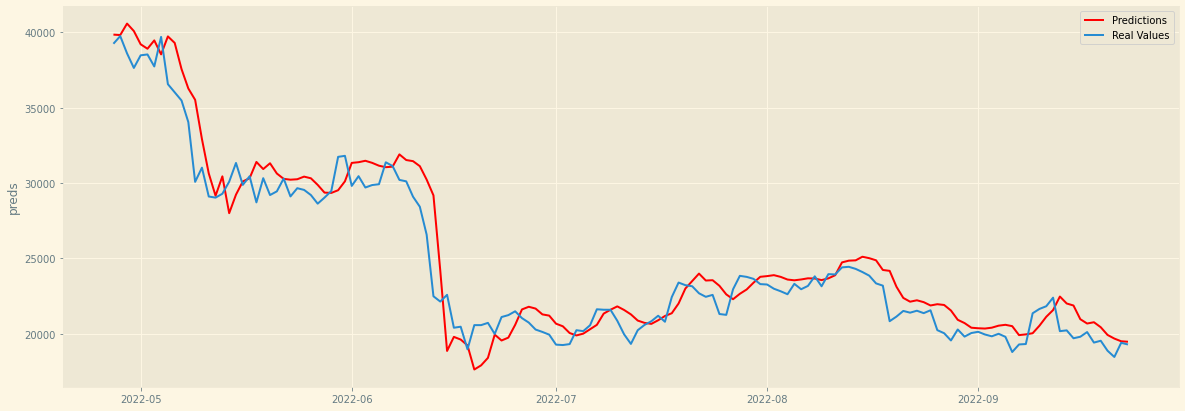

In [119]:
train_test_pred1=np.repeat(train_test_pred.reshape(-1,1),df2.shape[1],axis=-1)
y_pred_future = scaler.inverse_transform(train_test_pred1)[:,0]

forecast_copies=np.repeat(y_test.reshape(-1,1),df2.shape[1],axis=-1)
y_real = scaler.inverse_transform(forecast_copies)[:,0]


comparison = pd.DataFrame({"preds":y_pred_future,'real':y_real},index=dates[-150:])
comparison1 = comparison
plt.figure(figsize=(20,7))
sns.lineplot(x=comparison.index, y= comparison1.preds,color='red')
sns.lineplot(x=comparison.index, y= comparison1.real)
plt.legend(['Predictions', 'Real Values'], loc='upper right')

print(f'Mean Absolute Error for test data:', mean_absolute_error(comparison.preds,comparison.real))
print(f'Mean Absolute Percentage Error for test data:', mean_absolute_percentage_error(comparison.preds,comparison.real))
print(f'Mean Squared Error for test data:',mean_squared_error(comparison.preds,comparison.real))
print(f'Root Mean Squared Error for test data:',np.sqrt(mean_squared_error(comparison.preds,comparison.real)))
print(f'R2 Score for test data:', r2_score(comparison.preds,comparison.real))


In [120]:
train_test_pred.shape,y_pred_future.shape,y_real.shape,x_test.shape,df2.shape[1]

((150, 1), (150,), (150,), (150, 7, 3), 3)

In [121]:
date_train = pd.to_datetime(df['Unnamed: 0'].iloc[7:-299])
date_val = pd.to_datetime(df['Unnamed: 0'].iloc[-299:-150])
date_test  = pd.to_datetime(df['Unnamed: 0'].iloc[-150:])


In [122]:
train_pred = model.predict(x_train).flatten()
val_pred =model.predict(x_val).flatten()
test_pred = model.predict(x_test).flatten()

train_pred=np.repeat(train_pred.reshape(-1,1),df2.shape[1],axis=-1)
y_train = scaler.inverse_transform(train_pred)[:,0]

val_pred=np.repeat(val_pred.reshape(-1,1),df2.shape[1],axis=-1)
y_val = scaler.inverse_transform(val_pred)[:,0]
test_pred=np.repeat(test_pred.reshape(-1,1),df2.shape[1],axis=-1)
y_test = scaler.inverse_transform(test_pred)[:,0]

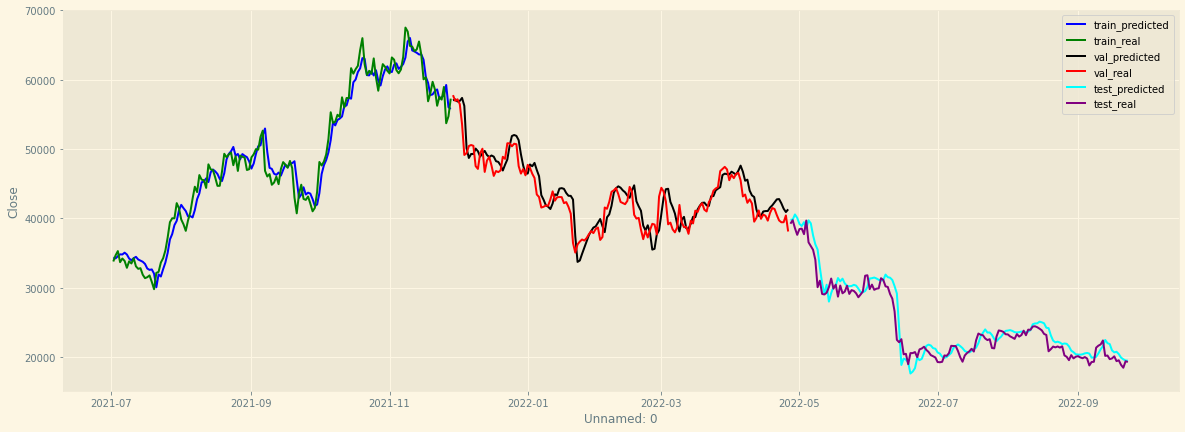

In [123]:
plt.figure(figsize=(20,7))
sns.lineplot(x=date_train.iloc[-150:],y=y_train[-150:],color='blue')
sns.lineplot(x=date_train.iloc[-150:],y=df.Close.iloc[-449:-299],color='green')
sns.lineplot(x=date_val,y=y_val,color='black')
sns.lineplot(x=date_val,y=df.Close.iloc[-299:-150],color='red')
sns.lineplot(x=date_test,y=y_test,color='cyan')
sns.lineplot(x=date_test,y=df.Close.iloc[-150:],color='purple')
plt.legend(labels=['train_predicted', 'train_real', 'val_predicted','val_real', 'test_predicted','test_real'])